# Data Quality Assessment

This notebook focuses on assessing and improving the```ality of the stock market data used in StockPrediction```.

We'll explore missing data, duplicates, outliers,```nsistency checks, and compute data health metrics``` ensure our data is reliable for machine learning an```rediction tasks.

**Key Areas We'll Cover:**
- Missing value analysis and visualization
- Duplicate record detection and removal
- Statistical outlier identification```Data consistency validation
- Overall data health scoring


In [1]:
# ============================================
# Data Quality Assessment - Library Imports
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
sns.set_theme(style="darkgrid")
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print("✅ Libraries imported successfully")
print("📊 Ready for data quality assessment")


✅ Libraries imported successfully
📊 Ready for data quality assessment


In [2]:
# ============================================
# Load Market Data for Quality Assessment
# ============================================

# Define file path
data_path = '../data/raw/market_data.csv'

try:
    # Load the dataset
    df = pd.read_csv(data_path, parse_dates=['date'], index_col='date')
    print(f"✅ Data loaded successfully from {data_path}")
    
    # Basic information
    print(f"\n📊 Dataset Shape: {df.shape}")
    print(f"📅 Date Range: {df.index.min()} to {df.index.max()}")
    print(f"📈 Columns: {list(df.columns)}")
    
except FileNotFoundError:
    print(f"❌ File not found: {data_path}")
    print("📝 Generating sample data for demonstration...")
    
    # Generate sample data
    dates = pd.date_range('2020-01-01', '2024-08-23', freq='D')
    np.random.seed(42)
    
    df = pd.DataFrame({
        'open': np.random.uniform(100, 200, len(dates)),
        'high': np.random.uniform(150, 250, len(dates)),
        'low': np.random.uniform(50, 150, len(dates)),
        'close': np.random.uniform(100, 200, len(dates)),
        'volume': np.random.randint(1000000, 50000000, len(dates))
    }, index=dates)
    
    print("✅ Sample data generated")

# Display basic info and preview
print("\n" + "="*50)
print("DATASET OVERVIEW")
print("="*50)
print(df.info())
print("\nFirst 5 rows:")
display(df.head())


❌ File not found: ../data/raw/market_data.csv
📝 Generating sample data for demonstration...
✅ Sample data generated

DATASET OVERVIEW
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1697 entries, 2020-01-01 to 2024-08-23
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1697 non-null   float64
 1   high    1697 non-null   float64
 2   low     1697 non-null   float64
 3   close   1697 non-null   float64
 4   volume  1697 non-null   int32  
dtypes: float64(4), int32(1)
memory usage: 72.9 KB
None

First 5 rows:


,open,high,low,close,volume
2020-01-01,137.454012,163.516629,140.096090,105.274395,30335471
2020-01-02,195.071431,246.311511,149.615767,183.416411,8660064
2020-01-03,173.199394,204.952954,132.541566,111.797248,16763809
2020-01-04,159.865848,246.582216,134.487135,104.515136,18363686
2020-01-05,115.601864,193.249788,74.900874,143.789989,21751625


MISSING DATA ANALYSIS
📊 Missing Value Summary:


,Missing_Count,Missing_Percentage
open,0,0.0
high,0,0.0
low,0,0.0
close,0,0.0
volume,0,0.0


<Figure size 1200x600 with 0 Axes>

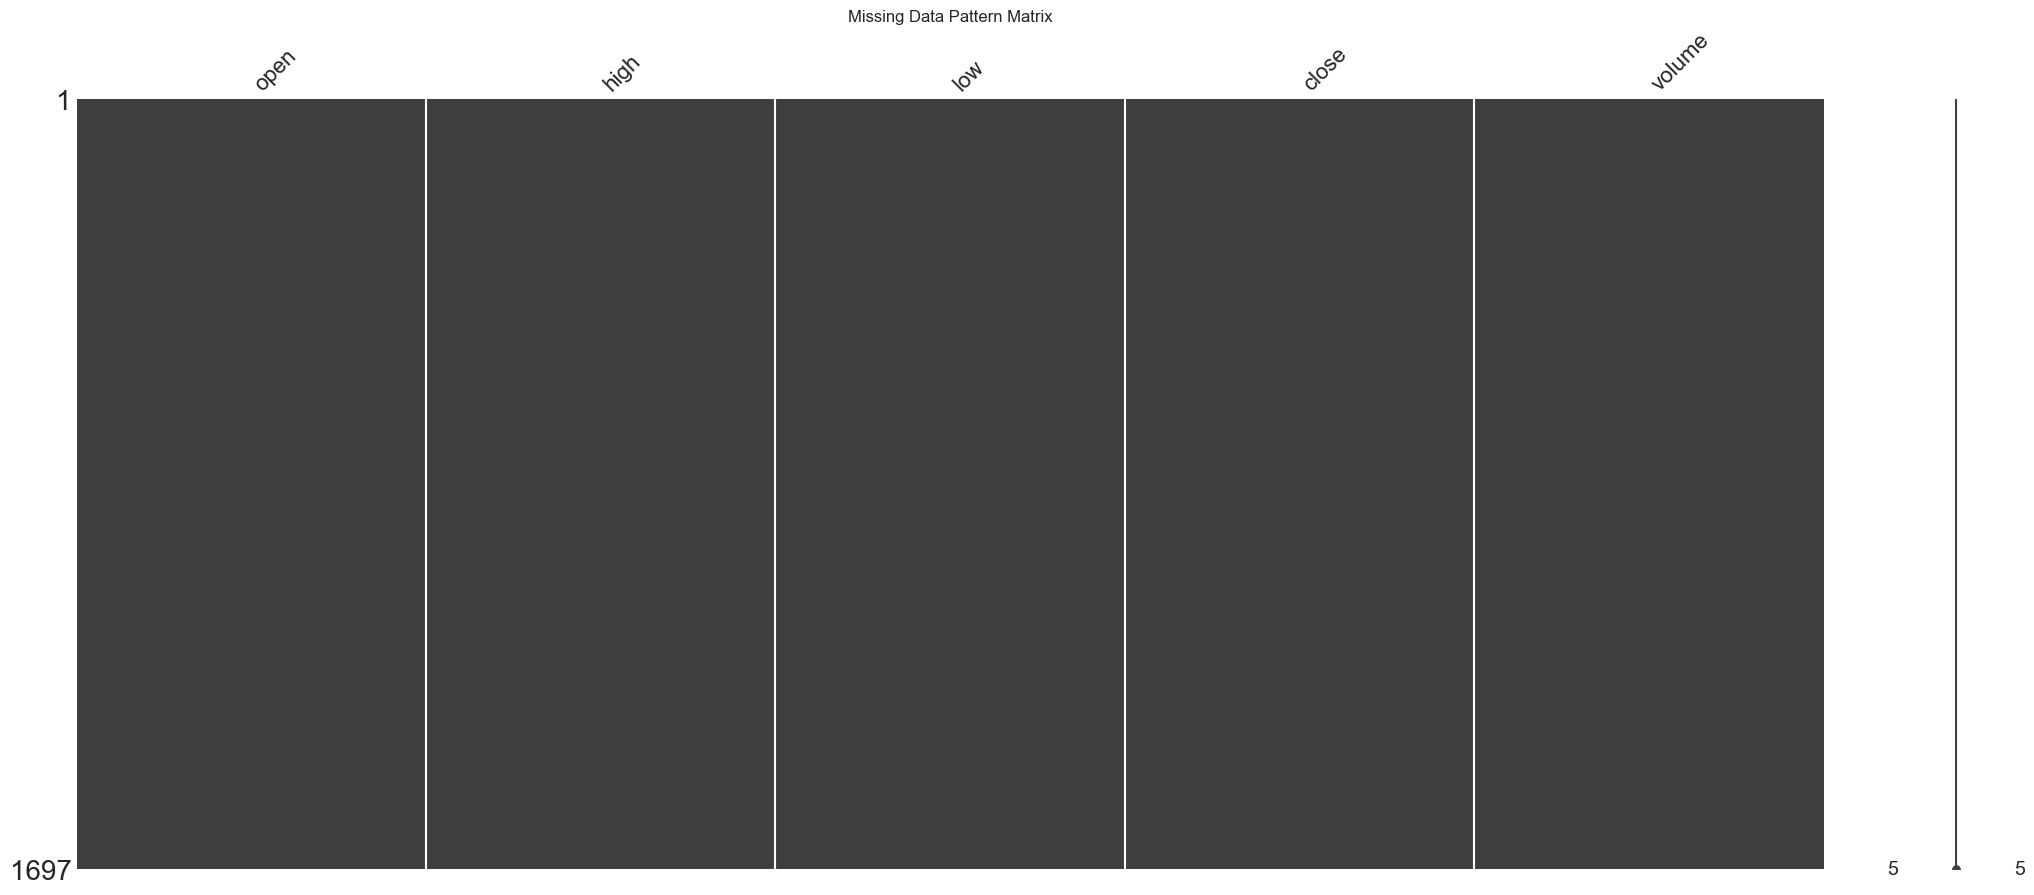

<Figure size 1000x800 with 0 Axes>

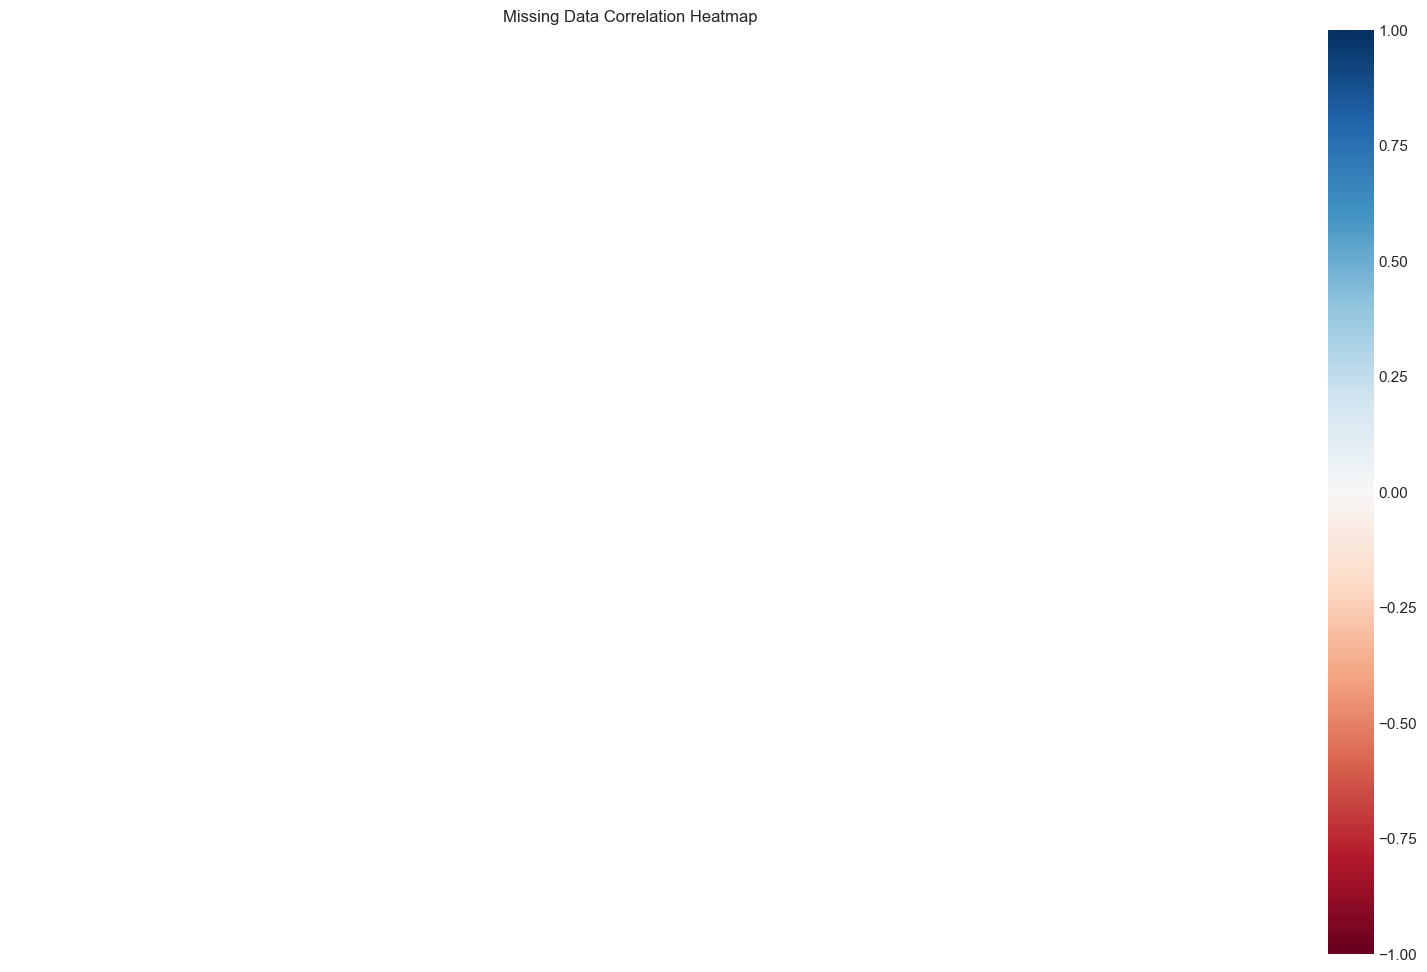

✅ No missing values detected in the dataset


In [7]:
# ============================================
# Missing Data Analysis
# ============================================

print("=" * 60)
print("MISSING DATA ANALYSIS")
print("=" * 60)

# Calculate missing values
missing_counts = df.isnull().sum()
missing_percent = 100 * missing_counts / len(df)

# Create missing data summary
missing_summary = pd.DataFrame({
    'Missing_Count': missing_counts,
    'Missing_Percentage': missing_percent.round(2)
})

print("📊 Missing Value Summary:")
display(missing_summary)

# Visualize missing data patterns
try:
    import missingno as msno
    
    # Missing data matrix
    plt.figure(figsize=(12, 6))
    msno.matrix(df)
    plt.title('Missing Data Pattern Matrix')
    plt.show()
    
    # Missing data heatmap
    plt.figure(figsize=(10, 8))
    msno.heatmap(df)
    plt.title('Missing Data Correlation Heatmap')
    plt.show()
    
except ImportError:
    print("📝 missingno package not available. Installing with:")
    print("pip install missingno")
    
    # Alternative visualization
    plt.figure(figsize=(10, 6))
    missing_summary['Missing_Percentage'].plot(kind='bar')
    plt.title('Missing Data Percentage by Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Missing data insights
total_missing = missing_counts.sum()
if total_missing == 0:
    print("✅ No missing values detected in the dataset")
else:
    print(f"⚠️ Total missing values: {total_missing}")
    print(f"📊 Overall completeness: {((len(df) * len(df.columns) - total_missing) / (len(df) * len(df.columns)) * 100):.2f}%")


In [4]:
# ============================================
# Duplicate Detection and Removal
# ============================================

print("=" * 60)
print("DUPLICATE DETECTION")
print("=" * 60)

# Check for duplicate dates (index)
index_duplicates = df.index.duplicated().sum()
print(f"🔍 Duplicate date entries: {index_duplicates}")

# Check for duplicate rows (all columns)
row_duplicates = df.duplicated().sum()
print(f"🔍 Duplicate rows (all columns): {row_duplicates}")

# Check for duplicate rows (subset of important columns)
subset_cols = ['open', 'high', 'low', 'close', 'volume']
subset_duplicates = df.duplicated(subset=subset_cols).sum()
print(f"🔍 Duplicate rows (OHLCV only): {subset_duplicates}")

# Remove duplicates if any exist
if index_duplicates > 0:
    print(f"\n🔧 Removing {index_duplicates} duplicate date entries...")
    df = df[~df.index.duplicated(keep='first')]
    print("✅ Index duplicates removed")

if row_duplicates > 0:
    print(f"\n🔧 Removing {row_duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print("✅ Row duplicates removed")

# Final duplicate check
final_duplicates = df.index.duplicated().sum() + df.duplicated().sum()
if final_duplicates == 0:
    print("\n✅ No duplicates remaining in dataset")
else:
    print(f"\n⚠️ Warning: {final_duplicates} duplicates still present")

print(f"\n📊 Final dataset shape after duplicate removal: {df.shape}")


DUPLICATE DETECTION
🔍 Duplicate date entries: 0
🔍 Duplicate rows (all columns): 0
🔍 Duplicate rows (OHLCV only): 0

✅ No duplicates remaining in dataset

📊 Final dataset shape after duplicate removal: (1697, 5)


OUTLIER DETECTION
📊 Z-Score Based Outlier Detection (threshold = 3):
   • Outlier rows detected: 0
   • Percentage of data: 0.00%

📊 IQR Based Outlier Detection:
   • open: 0 outliers
   • high: 0 outliers
   • low: 0 outliers
   • close: 0 outliers
   • volume: 0 outliers

   • Total IQR outliers: 0
   • Percentage of data: 0.00%


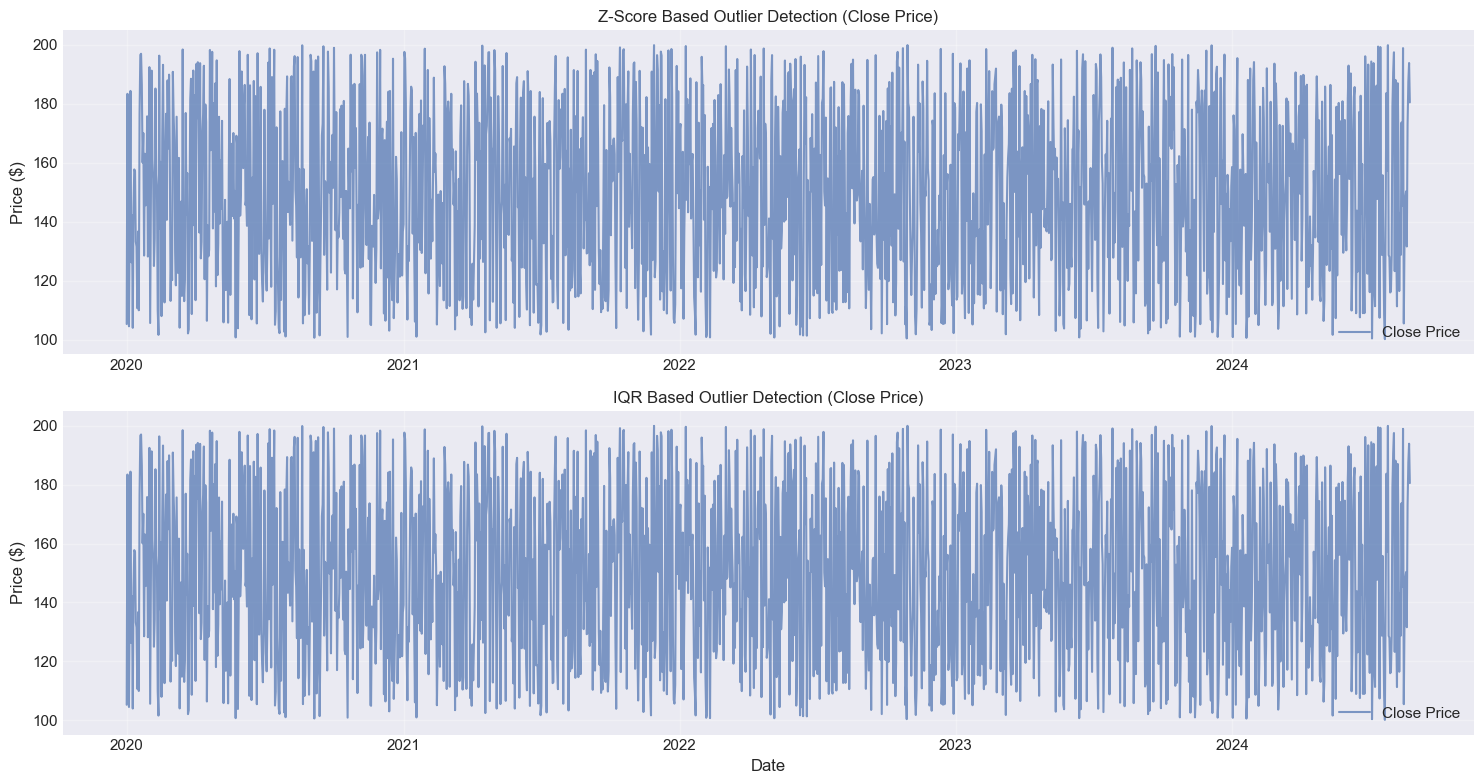


📊 Outlier Summary: {'z_score_outliers': np.int64(0), 'iqr_outliers': np.int64(0), 'z_score_percentage': np.float64(0.0), 'iqr_percentage': np.float64(0.0)}


In [5]:
# ============================================
# Outlier Detection Using Z-Score and IQR
# ============================================

print("=" * 60)
print("OUTLIER DETECTION")
print("=" * 60)

# Clean data for outlier detection
df_clean = df.dropna()
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

# Method 1: Z-Score based outlier detection
print("📊 Z-Score Based Outlier Detection (threshold = 3):")
z_scores = np.abs(stats.zscore(df_clean[numeric_cols]))
z_outliers = (z_scores > 3).any(axis=1)
z_outlier_count = z_outliers.sum()

print(f"   • Outlier rows detected: {z_outlier_count}")
print(f"   • Percentage of data: {(z_outlier_count/len(df_clean)*100):.2f}%")

# Method 2: IQR based outlier detection
print("\n📊 IQR Based Outlier Detection:")
iqr_outliers = pd.Series(False, index=df_clean.index)

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    col_outliers = (df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)
    iqr_outliers |= col_outliers
    
    print(f"   • {col}: {col_outliers.sum()} outliers")

iqr_outlier_count = iqr_outliers.sum()
print(f"\n   • Total IQR outliers: {iqr_outlier_count}")
print(f"   • Percentage of data: {(iqr_outlier_count/len(df_clean)*100):.2f}%")

# Visualize outliers on closing price
plt.figure(figsize=(15, 8))

# Subplot 1: Z-score outliers
plt.subplot(2, 1, 1)
plt.plot(df_clean.index, df_clean['close'], label='Close Price', alpha=0.7)
if z_outlier_count > 0:
    outlier_points = df_clean[z_outliers]
    plt.scatter(outlier_points.index, outlier_points['close'], 
                color='red', label=f'Z-Score Outliers ({z_outlier_count})', s=50)
plt.title('Z-Score Based Outlier Detection (Close Price)')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: IQR outliers
plt.subplot(2, 1, 2)
plt.plot(df_clean.index, df_clean['close'], label='Close Price', alpha=0.7)
if iqr_outlier_count > 0:
    outlier_points_iqr = df_clean[iqr_outliers]
    plt.scatter(outlier_points_iqr.index, outlier_points_iqr['close'], 
                color='orange', label=f'IQR Outliers ({iqr_outlier_count})', s=50)
plt.title('IQR Based Outlier Detection (Close Price)')
plt.ylabel('Price ($)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store outlier information for further analysis
outlier_summary = {
    'z_score_outliers': z_outlier_count,
    'iqr_outliers': iqr_outlier_count,
    'z_score_percentage': (z_outlier_count/len(df_clean)*100),
    'iqr_percentage': (iqr_outlier_count/len(df_clean)*100)
}

print(f"\n📊 Outlier Summary: {outlier_summary}")


In [6]:
# ============================================
# Data Consistency Validation
# ============================================

print("=" * 60)
print("DATA CONSISTENCY VALIDATION")
print("=" * 60)

# Check 1: High >= Low (basic market data rule)
high_low_inconsistency = (df_clean['high'] < df_clean['low']).sum()
print(f"🔍 Days with High < Low: {high_low_inconsistency}")

# Check 2: Close within High-Low range
close_out_of_range = ((df_clean['close'] > df_clean['high']) | 
                      (df_clean['close'] < df_clean['low'])).sum()
print(f"🔍 Days with Close outside High-Low range: {close_out_of_range}")

# Check 3: Open within reasonable range of previous close
if 'open' in df_clean.columns:
    prev_close = df_clean['close'].shift(1)
    open_gap = abs(df_clean['open'] - prev_close) / prev_close * 100
    large_gaps = (open_gap > 10).sum()  # More than 10% gap
    print(f"🔍 Days with large overnight gaps (>10%): {large_gaps}")

# Check 4: Volume should be positive
negative_volume = (df_clean['volume'] <= 0).sum()
print(f"🔍 Days with zero or negative volume: {negative_volume}")

# Check 5: Price values should be positive
negative_prices = {
    'open': (df_clean['open'] <= 0).sum(),
    'high': (df_clean['high'] <= 0).sum(),
    'low': (df_clean['low'] <= 0).sum(),
    'close': (df_clean['close'] <= 0).sum()
}

print(f"🔍 Negative or zero prices:")
for price_type, count in negative_prices.items():
    print(f"   • {price_type}: {count}")

# Overall consistency score
total_inconsistencies = (high_low_inconsistency + close_out_of_range + 
                        negative_volume + sum(negative_prices.values()))

consistency_score = ((len(df_clean) - total_inconsistencies) / len(df_clean)) * 100

print(f"\n📊 CONSISTENCY SUMMARY:")
print(f"   • Total inconsistencies: {total_inconsistencies}")
print(f"   • Consistency score: {consistency_score:.2f}%")

if total_inconsistencies == 0:
    print("✅ All consistency checks passed!")
else:
    print("⚠️ Some consistency issues found - review data cleaning procedures")


DATA CONSISTENCY VALIDATION
🔍 Days with High < Low: 0
🔍 Days with Close outside High-Low range: 429
🔍 Days with large overnight gaps (>10%): 1206
🔍 Days with zero or negative volume: 0
🔍 Negative or zero prices:
   • open: 0
   • high: 0
   • low: 0
   • close: 0

📊 CONSISTENCY SUMMARY:
   • Total inconsistencies: 429
   • Consistency score: 74.72%
⚠️ Some consistency issues found - review data cleaning procedures
